参考: https://qiita.com/sugulu_Ogawa_ISID/items/697bd03499c1de9cf082

In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import torch
from torch.utils.data import DataLoader

print(torch.__version__)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

1.11.0+cu113


device(type='cuda')

In [2]:
df = pd.DataFrame.from_dict(pd.read_pickle('../data/twitter/twitterJSA_data.pickle'))
lable2idx = {0:"ポジティブ&ネガティブ",
            1:"ポジティブ",
            2:"ネガティブ",
            3:"ニュートラル",
            4:"無関係"}
lable_length = 5

# data数削減
df = df.sample(n=7000, random_state=123)
df.head

<bound method NDFrame.head of              id  topic              status            label  \
260782  1152146  10026  649586508110757888  [0, 0, 0, 0, 1]   
328485  1394459  10022  703752483483430912  [0, 0, 1, 0, 0]   
493161  2672788  10021  691170800846548992  [0, 0, 0, 1, 0]   
83628    478577  10000  668649960359878656  [0, 0, 1, 0, 0]   
57522    473962  10000  667307740990083073  [0, 0, 0, 1, 0]   
...         ...    ...                 ...              ...   
40864    457206  10000  661404228057849856  [0, 0, 0, 0, 1]   
258538  1154205  10024  460976864593326081  [0, 0, 0, 1, 0]   
15994     28434  10000  527276031233646592  [0, 0, 1, 1, 0]   
469170  2152918  10025  699154791004409856  [0, 0, 0, 1, 0]   
413335  2021103  10024  678222887090700288  [0, 0, 0, 1, 0]   

                                                     text  
260782                   コーテク垢までシャープに絡みに行ってるやんけｗｗｗｗｗｗｗｗｗｗ  
328485  パナ機今日も録画準備に入った所で電源落ちたよね\nJスポ4CC男子フリーの頭切れてるよね\n...  
493161            寒波により強気なので\nとりあ

In [3]:
train_df, test_df = train_test_split(df, test_size=0.3, shuffle=True)
train_df, valid_df = train_test_split(train_df, test_size=0.2, shuffle=True)
print(train_df["label"].value_counts())
print(test_df["label"].value_counts())

[0, 0, 0, 0, 1]    2046
[0, 0, 0, 1, 0]    1440
[0, 0, 1, 0, 0]     167
[0, 1, 0, 0, 0]      98
[0, 0, 0, 1, 1]      85
[0, 0, 1, 1, 0]      33
[0, 1, 0, 1, 0]      16
[0, 0, 1, 0, 1]      13
[0, 1, 0, 0, 1]       9
[1, 0, 0, 0, 0]       7
[1, 0, 0, 1, 0]       5
[1, 0, 0, 0, 1]       1
Name: label, dtype: int64
[0, 0, 0, 0, 1]    1066
[0, 0, 0, 1, 0]     787
[0, 0, 1, 0, 0]      99
[0, 1, 0, 0, 0]      50
[0, 0, 0, 1, 1]      48
[0, 0, 1, 1, 0]      19
[0, 0, 1, 0, 1]      13
[0, 1, 0, 1, 0]       7
[0, 1, 0, 0, 1]       6
[1, 1, 0, 0, 0]       3
[1, 0, 0, 0, 0]       1
[1, 1, 1, 1, 1]       1
Name: label, dtype: int64


In [19]:
import torch
from transformers import AdamW, AutoTokenizer, AutoModelForMaskedLM, AutoModelForSequenceClassification
from transformers import ElectraTokenizer, ElectraForSequenceClassification, BertJapaneseTokenizer, BertForSequenceClassification
from transformers import ElectraForPreTraining, ElectraModel
# model_path = "cl-tohoku/bert-base-japanese"
model_path = "izumi-lab/electra-base-japanese-discriminator"
# model_path = "izumi-lab/electra-small-japanese-fin-discriminator"



In [21]:
tokenizer = BertJapaneseTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path, problem_type="multi_label_classification", num_labels=lable_length, )
# model = ElectraModel.from_pretrained(model_path)

# freeze layers except last layer
for param in model.parameters():
    param.requires_grad = False

last_layer = list(model.children())[-1]
print(f'except last layer: {last_layer}')
for param in last_layer.parameters():
    param.requires_grad = True

# model

Some weights of the model checkpoint at izumi-lab/electra-base-japanese-discriminator were not used when initializing ElectraForSequenceClassification: ['discriminator_predictions.dense_prediction.weight', 'discriminator_predictions.dense_prediction.bias', 'discriminator_predictions.dense.weight', 'discriminator_predictions.dense.bias']
- This IS expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing ElectraForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at izumi-lab/electra-base-japanese-discriminator and are newly ini

except last layer: ElectraClassificationHead(
  (dense): Linear(in_features=768, out_features=768, bias=True)
  (dropout): Dropout(p=0.1, inplace=False)
  (out_proj): Linear(in_features=768, out_features=5, bias=True)
)


In [13]:
max_len = 80
train_encoding = tokenizer(train_df["text"].to_list(), return_tensors="pt",padding=True, truncation=True, max_length=max_len)
valid_encoding = tokenizer(valid_df["text"].to_list(), return_tensors="pt",padding=True, truncation=True, max_length=max_len)
test_encoding = tokenizer(test_df["text"].to_list(), return_tensors="pt",padding=True, truncation=True, max_length=max_len)

In [ ]:
train_label = torch.tensor(train_df["label"].to_list())
valid_label = torch.tensor(valid_df["label"].to_list())
test_label = torch.tensor(test_df["label"].to_list())

In [ ]:
# 0 番目 の 5 トーク ン までの ID を 表示
print(train_encoding["input_ids"][ 0][: 50]) 
# 0 番目 の 5 トーク ン までの トー クン を デコード し て 表示
print(tokenizer.decode(train_encoding["input_ids"][0][:50]))

In [ ]:
class CreateDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels
    
    def __getitem__( self, idx):
        item = {key:torch.tensor(val[idx]).clone().detach() for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float32).clone().detach()
        return item
    
    def __len__( self):
        return len(self.labels)

train_dataset = CreateDataset(train_encoding, train_label)
val_dataset = CreateDataset(valid_encoding, valid_label)
test_dataset = CreateDataset(test_encoding, test_label)


In [ ]:
def saveModel(): 
    path = "./IzumiElectraModel_multilabel_bceloss.pth" 
    torch.save(model.state_dict(), path)

model = model.to(device)

In [25]:
loss_fn_list = [torch.nn.CrossEntropyLoss(), torch.nn.BCELoss(), torch.nn.BCEWithLogitsLoss, torch.nn.MSELoss(), torch.nn.MultiLabelMarginLoss(), torch.nn.L1Loss()]
loss_fn = loss_fn_list[1]
sigmoid_fn = torch.nn.Sigmoid()
train_loader = DataLoader(train_dataset, batch_size = 64, shuffle = True)
validate_loader = DataLoader(val_dataset, batch_size = 64, shuffle = True)

optimizer = AdamW(model.parameters(), lr=0.003)
model.train()
epochs = 30
train_losses = []
valid_losses = []
acc_epoc = []
best_accuracy = 0.0 

th = 0.8

#再学習
for epoch in range(epochs):
    running_train_loss = 0.0 
    running_accuracy = 0.0 
    running_vall_loss = 0.0 
    total = 0 

    # Training Loop 
    model.train()
    for batch in tqdm(train_loader):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)
        outputs = model(input_ids, attention_mask = attention_mask)
        logits = outputs.logits
        loss = loss_fn(sigmoid_fn(logits), labels)
        loss.backward()
        optimizer.step()
        
        running_train_loss +=loss.item()

    # Calculate training loss value 
    train_loss_value = running_train_loss/len(train_loader) 
    train_losses.append(train_loss_value)
    
    # Validation Loop 
    with torch.no_grad(): 
        model.eval() 
        for batch in tqdm(validate_loader): 
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels']
            outputs = model(input_ids, attention_mask = attention_mask)
            logits = outputs.logits
            val_loss = loss_fn(sigmoid_fn(logits).to('cpu'), labels)
            
            probs = sigmoid_fn(logits).to('cpu')

            # The label with the highest value will be our prediction 
            #_, predicted = torch.max(logits, 1) 
            predicted = torch.where(probs > th, torch.ones(len(labels), lable_length), torch.zeros(len(labels), lable_length))
            running_vall_loss += val_loss.item()
            total += logits.size(0) * logits.size(1)
            
            running_accuracy += (predicted == labels).sum().item()

    # Calculate validation loss value 
    val_loss_value = running_vall_loss/len(validate_loader)
    valid_losses.append(val_loss_value)
            
    # Calculate accuracy as the number of correct predictions in the validation batch divided by the total number of predictions done.  
    accuracy = (100 * running_accuracy / total)
    acc_epoc.append(accuracy)    

    # Save the model if the accuracy is the best 
    if accuracy > best_accuracy: 
        saveModel() 
        best_accuracy = accuracy

    print('Completed training batch', epoch, 'Training Loss is: %.4f' %train_loss_value, 'Validation Loss is: %.4f' %val_loss_value, 'Accuracy is %d %%' % (accuracy))

  0%|          | 0/62 [00:00<?, ?it/s]C:\Users\windo\AppData\Local\Temp\ipykernel_1240\825136160.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item = {key:torch.tensor(val[idx]).clone().detach() for key, val in self.encodings.items()}
C:\Users\windo\AppData\Local\Temp\ipykernel_1240\825136160.py:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  item['labels'] = torch.tensor(self.labels[idx], dtype=torch.float32).clone().detach()
100%|██████████| 16/16 [00:05<00:00,  2.97it/s]


Completed training batch 0 Training Loss is: 0.3496 Validation Loss is: 0.3385 Accuracy is 79 %


100%|██████████| 16/16 [00:05<00:00,  2.79it/s]


Completed training batch 1 Training Loss is: 0.3430 Validation Loss is: 0.3599 Accuracy is 79 %


100%|██████████| 16/16 [00:05<00:00,  2.78it/s]


Completed training batch 2 Training Loss is: 0.3454 Validation Loss is: 0.3403 Accuracy is 79 %


100%|██████████| 16/16 [00:05<00:00,  2.75it/s]


Completed training batch 3 Training Loss is: 0.3400 Validation Loss is: 0.3465 Accuracy is 79 %


100%|██████████| 16/16 [00:05<00:00,  2.71it/s]


Completed training batch 4 Training Loss is: 0.3385 Validation Loss is: 0.3303 Accuracy is 80 %


100%|██████████| 16/16 [00:05<00:00,  2.69it/s]


Completed training batch 5 Training Loss is: 0.3389 Validation Loss is: 0.3326 Accuracy is 80 %


100%|██████████| 16/16 [00:05<00:00,  2.67it/s]


Completed training batch 6 Training Loss is: 0.3364 Validation Loss is: 0.3286 Accuracy is 80 %


100%|██████████| 16/16 [00:06<00:00,  2.65it/s]


Completed training batch 7 Training Loss is: 0.3372 Validation Loss is: 0.3344 Accuracy is 80 %


100%|██████████| 16/16 [00:06<00:00,  2.64it/s]


Completed training batch 8 Training Loss is: 0.3368 Validation Loss is: 0.3229 Accuracy is 80 %


100%|██████████| 16/16 [00:06<00:00,  2.62it/s]


Completed training batch 9 Training Loss is: 0.3359 Validation Loss is: 0.3327 Accuracy is 80 %


100%|██████████| 16/16 [00:06<00:00,  2.60it/s]


Completed training batch 10 Training Loss is: 0.3323 Validation Loss is: 0.3298 Accuracy is 79 %


100%|██████████| 16/16 [00:06<00:00,  2.62it/s]


Completed training batch 11 Training Loss is: 0.3359 Validation Loss is: 0.3253 Accuracy is 80 %


100%|██████████| 16/16 [00:06<00:00,  2.61it/s]


Completed training batch 12 Training Loss is: 0.3316 Validation Loss is: 0.3240 Accuracy is 80 %


100%|██████████| 16/16 [00:06<00:00,  2.60it/s]


Completed training batch 13 Training Loss is: 0.3312 Validation Loss is: 0.3228 Accuracy is 80 %


100%|██████████| 16/16 [00:06<00:00,  2.59it/s]


Completed training batch 14 Training Loss is: 0.3306 Validation Loss is: 0.3235 Accuracy is 80 %


100%|██████████| 16/16 [00:06<00:00,  2.59it/s]


Completed training batch 15 Training Loss is: 0.3313 Validation Loss is: 0.3205 Accuracy is 80 %


100%|██████████| 16/16 [00:06<00:00,  2.59it/s]


Completed training batch 16 Training Loss is: 0.3330 Validation Loss is: 0.3213 Accuracy is 80 %


100%|██████████| 16/16 [00:06<00:00,  2.59it/s]


Completed training batch 17 Training Loss is: 0.3328 Validation Loss is: 0.3258 Accuracy is 80 %


100%|██████████| 16/16 [00:06<00:00,  2.58it/s]


Completed training batch 18 Training Loss is: 0.3320 Validation Loss is: 0.3190 Accuracy is 80 %


100%|██████████| 16/16 [00:06<00:00,  2.58it/s]


Completed training batch 19 Training Loss is: 0.3275 Validation Loss is: 0.3181 Accuracy is 80 %


100%|██████████| 16/16 [00:06<00:00,  2.58it/s]


Completed training batch 20 Training Loss is: 0.3317 Validation Loss is: 0.3251 Accuracy is 80 %


100%|██████████| 16/16 [00:06<00:00,  2.58it/s]


Completed training batch 21 Training Loss is: 0.3326 Validation Loss is: 0.3290 Accuracy is 80 %


100%|██████████| 16/16 [00:06<00:00,  2.58it/s]


Completed training batch 22 Training Loss is: 0.3314 Validation Loss is: 0.3168 Accuracy is 80 %


100%|██████████| 16/16 [00:06<00:00,  2.59it/s]


Completed training batch 23 Training Loss is: 0.3314 Validation Loss is: 0.3181 Accuracy is 80 %


100%|██████████| 16/16 [00:06<00:00,  2.58it/s]


Completed training batch 24 Training Loss is: 0.3288 Validation Loss is: 0.3220 Accuracy is 80 %


100%|██████████| 16/16 [00:06<00:00,  2.57it/s]


Completed training batch 25 Training Loss is: 0.3278 Validation Loss is: 0.3283 Accuracy is 80 %


100%|██████████| 16/16 [00:06<00:00,  2.58it/s]


Completed training batch 26 Training Loss is: 0.3299 Validation Loss is: 0.3390 Accuracy is 80 %


100%|██████████| 16/16 [00:06<00:00,  2.58it/s]


Completed training batch 27 Training Loss is: 0.3333 Validation Loss is: 0.3223 Accuracy is 80 %


100%|██████████| 16/16 [00:06<00:00,  2.59it/s]


Completed training batch 28 Training Loss is: 0.3293 Validation Loss is: 0.3197 Accuracy is 80 %


100%|██████████| 16/16 [00:06<00:00,  2.57it/s]

Completed training batch 29 Training Loss is: 0.3299 Validation Loss is: 0.3267 Accuracy is 80 %


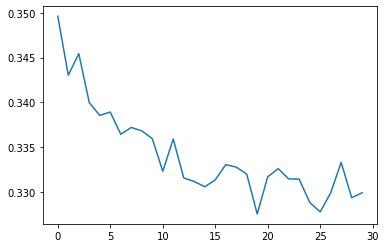

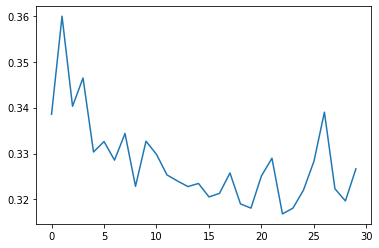

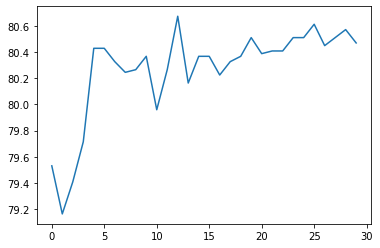

In [26]:
import matplotlib.pyplot as plt
import seaborn as sns
losses_ = [loss for loss in train_losses]
plt.plot(losses_)
plt.show()

losses_ = [loss for loss in valid_losses]
plt.plot(losses_)
plt.show()

losses_ = [loss for loss in acc_epoc]
plt.plot(losses_)
plt.show()


In [13]:
model.load_state_dict(torch.load("./model/IzumiElectraModel_multilabel_bceloss.pth" ))
model.to(device)
model.eval()
preds = []
sigmoid_fn = torch.nn.Sigmoid()
with torch.no_grad():
    for text in tqdm(test_df["text"].to_list()):
        inputs = tokenizer.encode(text, return_tensors="pt",padding=True, truncation=True, max_length=80).to(device)
        outputs = model(inputs)
        logits = outputs.logits
        
        probs = sigmoid_fn(logits).to('cpu')
        preds.append(probs)

100%|██████████| 2100/2100 [00:25<00:00, 83.50it/s]


In [17]:
correct_cnt = 0
th = 0.4
test_label = test_df["label"].to_list()
for idx in tqdm(range(len(preds))):
    pred = preds[idx]
    predicted = torch.where(pred > th, torch.ones(1, lable_length), torch.zeros(1, lable_length))
    ans_label = torch.tensor(test_label[idx])

    correct_cnt += (predicted == ans_label).sum().item()
    
acc = 100 * correct_cnt / (len(preds)*5)
print(f"Acc: {acc}%")

100%|██████████| 2100/2100 [00:00<00:00, 18258.79it/s]

Acc: 82.78095238095239%
